In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


In [3]:
df = pd.read_csv('../data/bodyPerformance.csv')
print(df.head())
print(df.columns)


    age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0  27.0      M      172.3      75.24        21.3       80.0     130.0   
1  25.0      M      165.0      55.80        15.7       77.0     126.0   
2  31.0      M      179.6      78.00        20.1       92.0     152.0   
3  32.0      M      174.5      71.10        18.4       76.0     147.0   
4  28.0      M      173.8      67.70        17.1       70.0     127.0   

   gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
0       54.9                     18.4            60.0          217.0     C  
1       36.4                     16.3            53.0          229.0     A  
2       44.8                     12.0            49.0          181.0     C  
3       41.4                     15.2            53.0          219.0     B  
4       43.5                     27.1            45.0          217.0     B  
Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gr

In [4]:

df['fitness'] = df['class'].map({
    'A': 1,  # Fit
    'B': 1,  # Fit
    'C': 0,  # Unfit
    'D': 0   # Unfit
})


print(df[['class', 'fitness']].head(10))
print(df['fitness'].value_counts())
print(df['fitness'].value_counts(normalize=True))


  class  fitness
0     C        0
1     A        1
2     C        0
3     B        1
4     B        1
5     B        1
6     D        0
7     B        1
8     C        0
9     B        1
fitness
0    6698
1    6695
Name: count, dtype: int64
fitness
0    0.500112
1    0.499888
Name: proportion, dtype: float64


In [5]:

df['BMI'] = df['weight_kg'] / (df['height_cm']/100) ** 2
df['bodyFatRatio'] = df['body fat_%'] / df['BMI']
df['strength_ratio'] = df['gripForce'] / df['weight_kg']
df['jump_ratio'] = df['broad jump_cm'] / df['height_cm']
df['situp_ratio'] = df['sit-ups counts'] / df['age']
df['flexibility_ratio'] = df['sit and bend forward_cm'] / df['height_cm']

df.head()


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,fitness,BMI,bodyFatRatio,strength_ratio,jump_ratio,situp_ratio,flexibility_ratio
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C,0,25.344179,0.840430,0.729665,1.259431,2.222222,0.106790
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A,1,20.495868,0.766008,0.652330,1.387879,2.120000,0.098788
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C,0,24.181428,0.831216,0.574359,1.007795,1.580645,0.066815
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B,1,23.349562,0.788023,0.582278,1.255014,1.656250,0.087106
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B,1,22.412439,0.762969,0.642541,1.248562,1.607143,0.155926


In [6]:
# Keep only essential raw features + engineered ones for better performance
drop_cols = [
    # Optionally drop fully redundant raw columns
    'broad jump_cm',
    'sit-ups counts',
    'sit and bend forward_cm'
]

df = df.drop(columns=drop_cols)


In [7]:
# Encode gender
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])

# Ensure numeric
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')

# Drop NaNs and zero or negative values
df = df.dropna().reset_index(drop=True)
cols_to_check = df.select_dtypes(include=['float64', 'int64']).columns
cols_to_check = cols_to_check.drop('gender', errors='ignore').drop('fitness', errors='ignore')
df = df[(df[cols_to_check] > 0).all(axis=1)].reset_index(drop=True)

df.head(10)


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,class,fitness,BMI,bodyFatRatio,strength_ratio,jump_ratio,situp_ratio,flexibility_ratio
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,C,0,25.344179,0.840430,0.729665,1.259431,2.222222,0.106790
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,A,1,20.495868,0.766008,0.652330,1.387879,2.120000,0.098788
2,31.0,1,179.6,78.00,20.1,92.0,152.0,44.8,C,0,24.181428,0.831216,0.574359,1.007795,1.580645,0.066815
3,32.0,1,174.5,71.10,18.4,76.0,147.0,41.4,B,1,23.349562,0.788023,0.582278,1.255014,1.656250,0.087106
4,28.0,1,173.8,67.70,17.1,70.0,127.0,43.5,B,1,22.412439,0.762969,0.642541,1.248562,1.607143,0.155926
5,36.0,0,165.4,55.40,22.0,64.0,119.0,23.8,B,1,20.250640,1.086385,0.429603,0.925030,0.750000,0.126965
6,42.0,0,164.5,63.70,32.2,72.0,135.0,22.7,D,0,23.540063,1.367881,0.356358,0.887538,0.428571,0.004863
7,33.0,1,174.9,77.20,36.9,84.0,137.0,45.9,B,1,25.236997,1.462139,0.594560,1.337907,1.272727,0.070326
8,54.0,1,166.8,67.50,27.6,85.0,165.0,40.4,C,0,24.261167,1.137620,0.598519,0.887290,0.629630,0.111511
9,28.0,1,185.0,84.60,14.4,81.0,156.0,57.9,B,1,24.718773,0.582553,0.684397,1.151351,1.964286,0.065405


In [8]:
X = df.drop(columns=['class', 'fitness'], errors='ignore')  # Drop class (optional)
y = df['fitness']

print(X.shape, y.shape)


(12621, 14) (12621,)


In [9]:
no_scale_cols = ['gender']
scale_cols = [col for col in X.columns if col not in no_scale_cols]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

X_train_scaled.head()


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,BMI,bodyFatRatio,strength_ratio,jump_ratio,situp_ratio,flexibility_ratio
7692,-0.710581,1,1.059155,1.477636,-0.191740,1.509090,1.548962,0.971899,1.163085,-0.588702,0.118186,-0.540263,0.948576,1.480626
8962,0.175138,0,-1.565230,-1.434788,0.355951,0.018628,0.049008,-0.635202,-0.935503,0.797423,0.485204,-0.525027,-0.749802,0.930900
6032,1.134666,1,-0.091260,0.017154,0.426167,1.322782,2.503478,0.182446,0.145393,0.343362,0.279039,0.300185,-0.785937,-0.864946
8599,1.429905,1,0.771551,0.948105,-0.388347,1.229629,1.412602,0.689951,0.714859,-0.636311,0.173597,0.399103,-0.561380,0.500934
475,-1.079630,0,-1.876801,-1.895993,-0.304087,-0.633449,-1.587305,-1.152106,-1.492716,0.324943,0.039524,0.292211,1.076693,1.118940


In [10]:
lr_base = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'
)

param_grid = {'C': [0.01, 0.1, 1, 3, 5, 10]}

grid_lr = GridSearchCV(
    lr_base,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_lr.fit(X_train_scaled, y_train)

lr_model = grid_lr.best_estimator_
lr_model


LogisticRegression(C=3, class_weight='balanced', max_iter=1000)

In [11]:
param_grid_knn = {
    'n_neighbors': [3,5,7,9,11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_knn.fit(X_train_scaled, y_train)
knn_model = grid_knn.best_estimator_
knn_model


KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [12]:
gb_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                           random_state=42)

In [13]:
# --- Fast Random Forest Tuning ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Base RF
rf_base = RandomForestClassifier(
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)

# Smaller param grid for fast search
param_grid = {
    'n_estimators': [200, 300, 400],       # fewer trees for faster search
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8],
    'bootstrap': [True]
}

# Randomized search: test 50 random combinations (much faster)
grid_rf = RandomizedSearchCV(
    rf_base,
    param_distributions=param_grid,
    n_iter=50,          # only 50 combinations instead of all
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

# Train on scaled features
grid_rf.fit(X_train_scaled, y_train)

# Best RF model
rf_model = grid_rf.best_estimator_
print("Best Random Forest Hyperparameters:\n", rf_model)


Best Random Forest Hyperparameters:
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.8, min_samples_leaf=2, n_estimators=300,
                       n_jobs=-1, random_state=42)


In [14]:
def evaluate(model, X_test_scaled, y_test):
    preds = model.predict(X_test_scaled)
    probs = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else None

    print("Accuracy:", accuracy_score(y_test, preds))
    if probs is not None:
        print("ROC AUC:", roc_auc_score(y_test, probs))
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    print("-"*50)


In [15]:
print("Logistic Regression")
evaluate(lr_model, X_test_scaled, y_test)



Logistic Regression
Accuracy: 0.7968316831683169
ROC AUC: 0.8800154150929376
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1186
           1       0.81      0.81      0.81      1339

    accuracy                           0.80      2525
   macro avg       0.80      0.80      0.80      2525
weighted avg       0.80      0.80      0.80      2525

[[ 929  257]
 [ 256 1083]]
--------------------------------------------------


In [16]:
print("KNN")
evaluate(knn_model, X_test_scaled, y_test)




KNN
Accuracy: 0.7908910891089109
ROC AUC: 0.8705919320123875
              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1186
           1       0.76      0.89      0.82      1339

    accuracy                           0.79      2525
   macro avg       0.80      0.78      0.79      2525
weighted avg       0.80      0.79      0.79      2525

[[ 807  379]
 [ 149 1190]]
--------------------------------------------------


In [17]:
print("Random Forest")
evaluate(rf_model, X_test_scaled, y_test)



Random Forest
Accuracy: 0.8403960396039604
ROC AUC: 0.9203572422600239
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1186
           1       0.82      0.89      0.85      1339

    accuracy                           0.84      2525
   macro avg       0.84      0.84      0.84      2525
weighted avg       0.84      0.84      0.84      2525

[[ 934  252]
 [ 151 1188]]
--------------------------------------------------


In [18]:
print("Gradient Boosting")
evaluate(gb_model, X_test_scaled, y_test)

Gradient Boosting
Accuracy: 0.8534653465346534
ROC AUC: 0.9298311014612853
              precision    recall  f1-score   support

           0       0.88      0.79      0.84      1186
           1       0.83      0.91      0.87      1339

    accuracy                           0.85      2525
   macro avg       0.86      0.85      0.85      2525
weighted avg       0.86      0.85      0.85      2525

[[ 939  247]
 [ 123 1216]]
--------------------------------------------------


In [19]:
importances = rf_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

print("Feature Importance Ranking:\n")
for i in sorted_idx:
    print(f"{feature_names[i]} : {importances[i]:.4f}")


Feature Importance Ranking:

flexibility_ratio : 0.3321
strength_ratio : 0.1434
situp_ratio : 0.0991
age : 0.0855
jump_ratio : 0.0677
bodyFatRatio : 0.0413
height_cm : 0.0356
body fat_% : 0.0338
weight_kg : 0.0326
BMI : 0.0325
gripForce : 0.0313
systolic : 0.0274
diastolic : 0.0247
gender : 0.0131


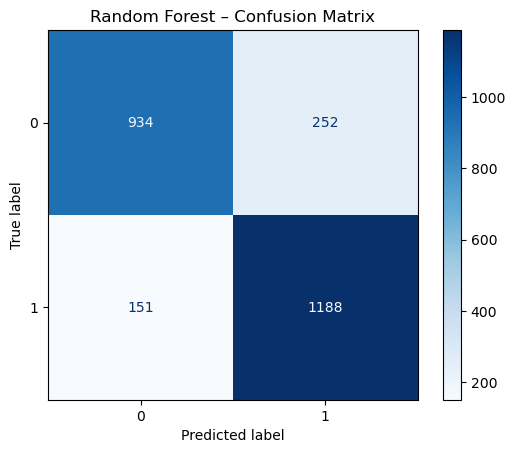

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test_scaled,
    y_test,
    cmap='Blues'
)

plt.title("Random Forest – Confusion Matrix")
plt.show()


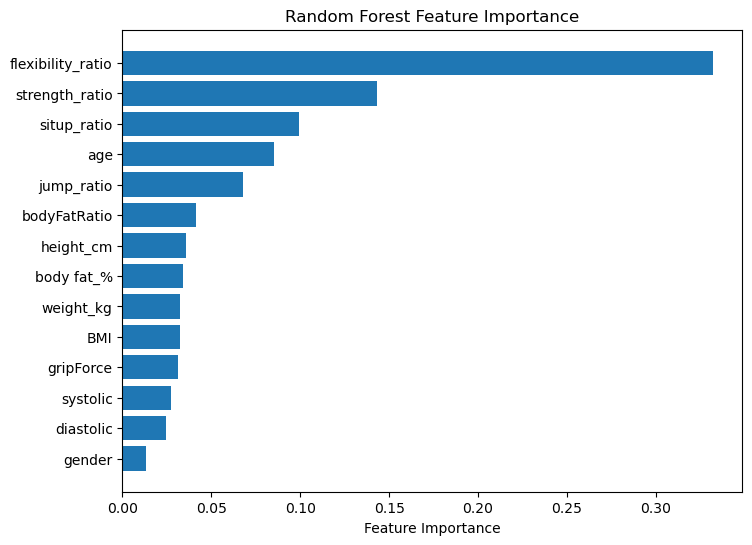

In [21]:
importances = rf_model.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


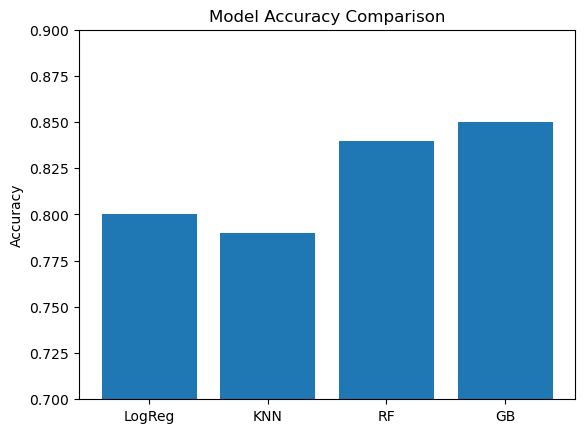

In [22]:
models = ['LogReg', 'KNN', 'RF', 'GB']
accuracies = [0.80, 0.79, 0.84, 0.85]

plt.bar(models, accuracies)
plt.ylim(0.7, 0.9)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()
